## 1. Load libraries

In [78]:
import pandas as pd
from datetime import date
import seaborn as sns
import numpy as np
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

## 2. Load dataset 

In [2]:
sales = pd.read_csv("data/sales_train.csv")

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales.shape

(2935849, 6)

In [5]:
test_df = pd.read_csv("data/test.csv").set_index("ID")

In [6]:
test_df.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [7]:
test_df.shape

(214200, 2)

In [8]:
shops = pd.read_csv("data/shops.csv")

In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
shops.shape

(60, 2)

In [11]:
items = pd.read_csv("data/items.csv")

In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
items.shape

(22170, 3)

In [14]:
item_cats = pd.read_csv("data/item_categories.csv")

In [15]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
item_cats.shape

(84, 2)

## 3. Data Preprocessing

In [17]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [18]:
sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y")

In [19]:
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [20]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


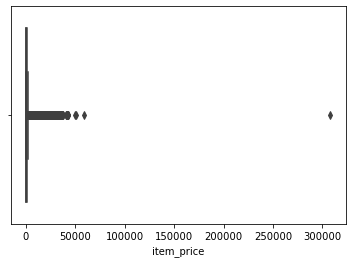

In [21]:
ax = sns.boxplot(x = sales["item_price"])

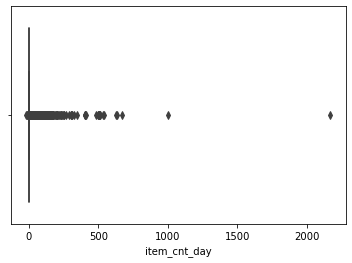

In [22]:
ax = sns.boxplot(x = sales["item_cnt_day"])

For outliers, we remove items with price > 100000 and sales > 1001.

In [23]:
sales = sales[sales["item_price"] < 100000]
sales = sales[sales["item_cnt_day"] < 1000]

There is one item with price below zero, so we replace its price with median.

In [24]:
sales[sales["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [25]:
sales.loc[sales["item_price"] < 0, "item_price"] = sales[
    (sales["shop_id"] == 32)
    & (sales["item_id"] == 2973)
    & (sales["date_block_num"] == 4)
    & (sales["item_price"] > 0)
]["item_price"].median()

We remove some duplicated shops.

In [27]:
sales.loc[sales["shop_id"] == 0, "shop_id"] = 57
test_df.loc[test_df["shop_id"] == 0, "shop_id"] = 57

sales.loc[sales["shop_id"] == 1, "shop_id"] = 58
test_df.loc[test_df["shop_id"] == 1, "shop_id"] = 58

sales.loc[sales["shop_id"] == 10, "shop_id"] = 11
test_df.loc[test_df["shop_id"] == 10, "shop_id"] = 11

In [30]:
shops.loc[
    shops["shop_name"] == 'Сергиев Посад ТЦ "7Я"', "shop_name"
] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
shops["city_code"] = LabelEncoder().fit_transform(shops["city"])
shops = shops[["shop_id", "city_code"]]

item_cats["split"] = item_cats["item_category_name"].str.split("-")
item_cats["type"] = item_cats["split"].map(lambda x: x[0].strip())
item_cats["type_code"] = LabelEncoder().fit_transform(item_cats["type"])
# if subtype is nan then type
item_cats["subtype"] = item_cats["split"].map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)
item_cats["subtype_code"] = LabelEncoder().fit_transform(item_cats["subtype"])
item_cats = item_cats[["item_category_id", "type_code", "subtype_code"]]

items.drop(["item_name"], axis=1, inplace=True)

In [34]:
len(set(test_df["item_id"]) - set(test_df["item_id"]).intersection(set(sales["item_id"])))

363

There are `363` item_id which are in `test_df` and not in `sales`.

## 4. Feature Engineering

In [35]:
features = []

In [36]:
cols = ["date_block_num", "shop_id", "item_id"]

for i in range(34):
    sale = sales[sales["date_block_num"] == i]
    features.append(
        np.array(list(product([i], sale["shop_id"].unique(), sale["item_id"].unique())))
    )

features = pd.DataFrame(np.vstack(features), columns=cols)
features.sort_values(cols, inplace=True)
features.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [37]:
sales["revenue"] = sales["item_price"] * sales["item_cnt_day"]

In [38]:
group = sales.groupby(["date_block_num", "shop_id", "item_id"]).agg(
    {"item_cnt_day": ["sum"]}
)
group.columns = ["item_cnt_month"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=cols, how="left")
features.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,NaN
1,0,2,27,1.0
2,0,2,28,NaN
3,0,2,29,NaN
4,0,2,32,NaN


In [39]:
features["item_cnt_month"] = features["item_cnt_month"].fillna(0).clip(0,20)

In [40]:
test_df["date_block_num"] = 34

In [41]:
features = pd.concat([features, test_df], ignore_index=True, sort=False, keys=cols)
features.fillna(0, inplace=True)
features.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [42]:
features = pd.merge(features, shops, on=["shop_id"], how="left")
features = pd.merge(features, items, on=["item_id"], how="left")
features = pd.merge(features, item_cats, on=["item_category_id"], how="left")
features.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [43]:
def lag_feature(df, lags, col):
    tmp = df[["date_block_num", "shop_id", "item_id", col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = [
            "date_block_num",
            "shop_id",
            "item_id",
            col + "_lag_" + str(i),
        ]
        shifted["date_block_num"] += i
        df = pd.merge(
            df, shifted, on=["date_block_num", "shop_id", "item_id"], how="left"
        )
    return df

In [44]:
features = lag_feature(features, [1, 2, 3, 6, 12], "item_cnt_month")
features.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


### Mean Encodings

In [45]:
group = features.groupby(["date_block_num"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace=True)
features = pd.merge(features, group, on=["date_block_num"], how="left")

features = lag_feature(features, [1], "date_avg_item_cnt")
features.drop(["date_avg_item_cnt"], axis=1, inplace=True)

In [46]:
group = features.groupby(["date_block_num", "item_id"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_item_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "item_id"], how="left")
features = lag_feature(features, [1, 2, 3, 6, 12], "date_item_avg_item_cnt")
features.drop(["date_item_avg_item_cnt"], axis=1, inplace=True)

In [47]:
group = features.groupby(["date_block_num", "shop_id"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "shop_id"], how="left")
features = lag_feature(features, [1, 2, 3, 6, 12], "date_shop_avg_item_cnt")
features.drop(["date_shop_avg_item_cnt"], axis=1, inplace=True)

In [48]:
group = features.groupby(["date_block_num", "item_category_id"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_cat_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "item_category_id"], how="left")
features = lag_feature(features, [1], "date_cat_avg_item_cnt")
features.drop(["date_cat_avg_item_cnt"], axis=1, inplace=True)

In [49]:
group = features.groupby(["date_block_num", "shop_id", "item_category_id"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_shop_cat_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(
    features, group, on=["date_block_num", "shop_id", "item_category_id"], how="left"
)
features = lag_feature(features, [1], "date_shop_cat_avg_item_cnt")
features.drop(["date_shop_cat_avg_item_cnt"], axis=1, inplace=True)

In [50]:
group = features.groupby(["date_block_num", "shop_id", "type_code"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_shop_type_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(
    features, group, on=["date_block_num", "shop_id", "type_code"], how="left"
)

features = lag_feature(features, [1], "date_shop_type_avg_item_cnt")
features.drop(["date_shop_type_avg_item_cnt"], axis=1, inplace=True)

In [51]:
group = features.groupby(["date_block_num", "shop_id", "subtype_code"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_shop_subtype_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(
    features, group, on=["date_block_num", "shop_id", "subtype_code"], how="left"
)

features = lag_feature(features, [1], "date_shop_subtype_avg_item_cnt")
features.drop(["date_shop_subtype_avg_item_cnt"], axis=1, inplace=True)

In [52]:
group = features.groupby(["date_block_num", "city_code"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_city_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "city_code"], how="left")

features = lag_feature(features, [1], "date_city_avg_item_cnt")
features.drop(["date_city_avg_item_cnt"], axis=1, inplace=True)

In [53]:
group = features.groupby(["date_block_num", "item_id", "city_code"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_item_city_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(
    features, group, on=["date_block_num", "item_id", "city_code"], how="left"
)

features = lag_feature(features, [1], "date_item_city_avg_item_cnt")
features.drop(["date_item_city_avg_item_cnt"], axis=1, inplace=True)

In [54]:
group = features.groupby(["date_block_num", "type_code"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_type_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "type_code"], how="left")

features = lag_feature(features, [1], "date_type_avg_item_cnt")
features.drop(["date_type_avg_item_cnt"], axis=1, inplace=True)

In [55]:
group = features.groupby(["date_block_num", "subtype_code"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_subtype_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "subtype_code"], how="left")

features = lag_feature(features, [1], "date_subtype_avg_item_cnt")
features.drop(["date_subtype_avg_item_cnt"], axis=1, inplace=True)

In [57]:
group = sales.groupby(["item_id"]).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["item_id"], how="left")

group = sales.groupby(["date_block_num", "item_id"]).agg({"item_price": ["mean"]})
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "item_id"], how="left")

lags = [1, 2, 3, 4, 5, 6]
features = lag_feature(features, lags, "date_item_avg_item_price")

for i in lags:
    features["delta_price_lag_" + str(i)] = (
        features["date_item_avg_item_price_lag_" + str(i)]
        - features["item_avg_item_price"]
    ) / features["item_avg_item_price"]


def select_trend(row):
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0


features["delta_price_lag"] = features.apply(select_trend, axis=1)
features["delta_price_lag"].fillna(0, inplace=True)


fetures_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    fetures_to_drop += ["date_item_avg_item_price_lag_" + str(i)]
    fetures_to_drop += ["delta_price_lag_" + str(i)]

features.drop(fetures_to_drop, axis=1, inplace=True)

In [58]:
group = sales.groupby(["date_block_num", "shop_id"]).agg({"revenue": ["sum"]})
group.columns = ["date_shop_revenue"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "shop_id"], how="left")

group = group.groupby(["shop_id"]).agg({"date_shop_revenue": ["mean"]})
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["shop_id"], how="left")

features["delta_revenue"] = (
    features["date_shop_revenue"] - features["shop_avg_revenue"]
) / features["shop_avg_revenue"]

features = lag_feature(features, [1], "delta_revenue")

features.drop(
    ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"], axis=1, inplace=True
)

In [59]:
features['month'] = features['date_block_num'] % 12

In [60]:
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
features["days"] = features["month"].map(days)

In [63]:
cache = {}
features["item_shop_last_sale"] = -1

for idx, row in features.iterrows():
    key = str(row.item_id) + " " + str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        features.at[idx, "item_shop_last_sale"] = (
            row.date_block_num - last_date_block_num
        )
        cache[key] = row.date_block_num

In [64]:
cache = {}
features["item_last_sale"] = -1

for idx, row in features.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            features.at[idx, "item_last_sale"] = (
                row.date_block_num - last_date_block_num
            )
            cache[key] = row.date_block_num

In [65]:
features["item_shop_first_sale"] = features["date_block_num"] - features.groupby(
    ["item_id", "shop_id"]
)["date_block_num"].transform("min")
features["item_first_sale"] = features["date_block_num"] - features.groupby("item_id")[
    "date_block_num"
].transform("min")

In [66]:
features = features[features.date_block_num > 11]

In [67]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

features = fill_na(features)

In [68]:
features.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,...,1.034303,1.075009,-0.282795,1.211909,0,31,1,1,12,12
4488711,12,2,30,0.0,0,40,11,4,0.0,0.0,...,0.269904,0.291505,-0.483264,1.211909,0,31,1,1,11,11
4488712,12,2,31,0.0,0,37,11,1,0.0,0.0,...,0.269904,0.233994,-0.137618,1.211909,0,31,1,1,11,11
4488713,12,2,32,1.0,0,40,11,4,0.0,0.0,...,0.269904,0.291505,-0.407143,1.211909,0,31,-1,1,12,12
4488714,12,2,33,1.0,0,37,11,1,1.0,2.0,...,0.269904,0.233994,-0.225177,1.211909,0,31,1,1,12,12


In [69]:
features.to_pickle("data/data.pkl")

## 5.Build Models

In [71]:
data = pd.read_pickle("data/data.pkl")

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [72]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [73]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[14:15:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05121	validation_1-rmse:1.04052
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.96521	validation_1-rmse:0.97928
[2]	validation_0-rmse:0.91786	validation_1-rmse:0.94924
[3]	validation_0-rmse:0.88787	validation_1-rmse:0.93433
[4]	validation_0-rmse:0.86670	validation_1-rmse:0.92226
[5]	validation_0-rmse:0.85285	validation_1-rmse:0.91855
[6]	validation_0-rmse:0.84544	validation_1-rmse:0.91982
[7]	validation_0-rmse:0.83998	validation_1-rmse:0.91846
[8]	validation_0-rmse:0.83623	validation_1-rmse:0.91685
[9]	validation_0-rmse:0.83222	validation_1-rmse:0.91671
[10]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [87]:
feature_name = X_train.columns.tolist()

params = {
    "objective": "mse",
    "metric": "rmse",
    "num_leaves": 2 ** 7 - 1,
    "learning_rate": 0.005,
    "feature_fraction": 0.75,
    "bagging_fraction": 0.75,
    "bagging_freq": 5,
    "seed": 1,
    "verbose": 1,
}

lgb_train = lgb.Dataset(X_train[feature_name], y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], y_valid, reference=lgb_train)

evals_result = {}
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=3000,
    valid_sets=(lgb_train, lgb_eval),
    feature_name=feature_name,
    verbose_eval=5,
    evals_result=evals_result,
    early_stopping_rounds=100,
)

In [74]:
y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({"ID": test_df.index, "item_cnt_month": y_test})
submission.to_csv("data/submission.csv", index=False)